In [0]:
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Activation, Concatenate
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [0]:
batch_size = 128
epochs = 100
lr0 = 0.1

In [0]:
def linear_decay(epoch):
    epochs_drop = 20
    drop = 0.5
    lrate = lr0 * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(linear_decay)

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [0]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.1)

In [0]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization=True
)

test_datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization=True
)

In [0]:
train_datagen.fit(x_train)
valid_datagen.fit(x_valid)
test_datagen.fit(x_test)

In [0]:
def fire_module(x, s1x1, e1x1, e3x3, name):
    #Squeeze layer
    squeeze = Conv2D(s1x1, (1, 1), activation='relu', padding='valid', kernel_initializer='glorot_uniform', name = name + 's1x1')(x)
    squeeze_bn = BatchNormalization(name=name+'sbn')(squeeze)
    
    #Expand 1x1 layer and 3x3 layer are parallel

    #Expand 1x1 layer
    expand1x1 = Conv2D(e1x1, (1, 1), activation='relu', padding='valid', kernel_initializer='glorot_uniform', name = name + 'e1x1')(squeeze_bn)
    
    #Expand 3x3 layer
    expand3x3 = Conv2D(e3x3, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform', name = name +  'e3x3')(squeeze_bn)
    
    #Concatenate expand1x1 and expand 3x3 at filters
    output = Concatenate(axis = 3, name=name)([expand1x1, expand3x3])
    
    return output

In [0]:
def SqueezeNet(height, width, channel):
    inputs = Input(shape=(height, width, channel))
    conv1 = Conv2D(96, kernel_size=(3, 3), strides=(2, 2),  padding='same', activation='relu', name = 'Conv1')(inputs)
    maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='Maxpool1')(conv1)
    batch1 = BatchNormalization(name='Batch1')(maxpool1)
#     fire2 = fire_module(batch1, 16, 64, 64, "Fire2")
#     fire3 = fire_module(fire2, 16, 64, 64, "Fire3")
    fire4 = fire_module(batch1, 32, 128, 128, "Fire2")
    maxpool4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='Maxpool2')(fire4)
#     fire5 = fire_module(maxpool4, 32, 128, 128, "Fire5")
    fire6 = fire_module(maxpool4, 48, 192, 192, "Fire3")
    fire7 = fire_module(fire6, 48, 192, 192, "Fire4")
    fire8 = fire_module(fire7, 48, 192, 192, "Fire5")
    maxpool8 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='Maxpool5')(fire8)
#     fire9 = fire_module(maxpool8, 64, 256, 256, "Fire9")
    dropout = Dropout(0.5, name="Dropout")(maxpool8)
    conv10 = Conv2D(10, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name='Conv6')(dropout)
    batch10 = BatchNormalization(name='Batch6')(conv10)
    avgpool10 = GlobalAveragePooling2D(name='GlobalAvgPool6')(batch10)
    softmax = Activation('softmax')(avgpool10)
    
    squeezenet = Model(inputs=inputs, outputs=softmax)
    return squeezenet

In [0]:
squeezenet = SqueezeNet(32, 32, 3)
sgd = SGD(lr = lr0, momentum = 0.9, nesterov=False)
squeezenet.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [0]:
squeezenet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 96)   2688        input_2[0][0]                    
__________________________________________________________________________________________________
Maxpool1 (MaxPooling2D)         (None, 8, 8, 96)     0           Conv1[0][0]                      
__________________________________________________________________________________________________
Batch1 (BatchNormalization)     (None, 8, 8, 96)     384         Maxpool1[0][0]                   
__________________________________________________________________________________________________
Fire2s1x1 

In [0]:
callbacks_list = [lrate]
squeezenet_his = squeezenet.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size), 
                                    steps_per_epoch = len(x_train) / batch_size, 
                                    epochs = epochs, 
                                   validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=batch_size),
                                   validation_steps=len(x_valid) / batch_size,
                                          callbacks=callbacks_list)

Epoch 1/100
352/351 [==============================] - 30s 87ms/step - loss: 1.6992 - acc: 0.3682 - val_loss: 1.5922 - val_acc: 0.4278
Epoch 2/100
352/351 [==============================] - 30s 84ms/step - loss: 1.3704 - acc: 0.5038 - val_loss: 1.4814 - val_acc: 0.4874
Epoch 3/100
352/351 [==============================] - 30s 86ms/step - loss: 1.2052 - acc: 0.5741 - val_loss: 1.3062 - val_acc: 0.5558
Epoch 4/100
352/351 [==============================] - 30s 85ms/step - loss: 1.1066 - acc: 0.6086 - val_loss: 1.0602 - val_acc: 0.6254
Epoch 5/100
352/351 [==============================] - 30s 86ms/step - loss: 1.0295 - acc: 0.6385 - val_loss: 1.5706 - val_acc: 0.5232
Epoch 6/100
352/351 [==============================] - 30s 84ms/step - loss: 0.9743 - acc: 0.6590 - val_loss: 1.1795 - val_acc: 0.6142
Epoch 7/100
352/351 [==============================] - 30s 86ms/step - loss: 0.9219 - acc: 0.6783 - val_loss: 1.0656 - val_acc: 0.6318
Epoch 8/100
352/351 [==============================] - 

In [0]:
squeezenet.save_weights("gdrive/My\ Drive/colab/squeezenet_old.h5")

OSError: ignored

In [0]:
results = squeezenet.evaluate_generator(test_datagen.flow(x_test, y_test, batch_size=batch_size), steps=len(x_test) / batch_size)
print("Test Accuracy %f" % (results[1] * 100))

Test Accuracy 80.970000


## **Plot**

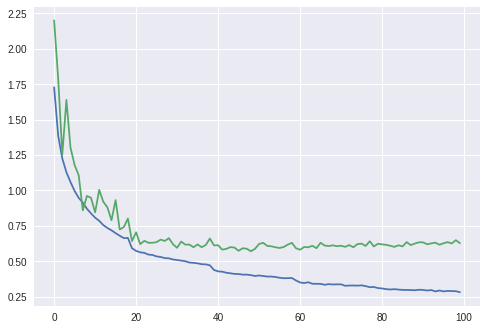

In [0]:
plt.plot(squeezenet_his.history['loss'])
plt.plot(squeezenet_his.history['val_loss'])

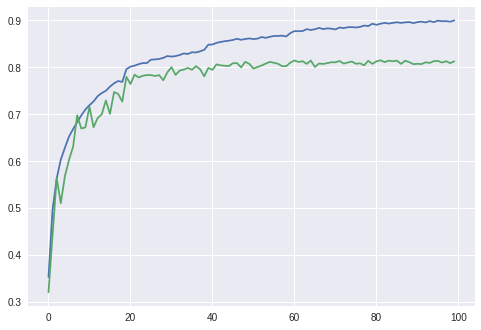

In [0]:
plt.plot(squeezenet_his.history['acc'])
plt.plot(squeezenet_his.history['val_acc'])

In [0]:
print("# of Parameter Reduction: ~%fx" % (22559626 / 378914))

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_predict = squeezenet.predict(x_valid)
#y_t =  np.argmax(y_valid, axis=1)
#y_p =  np.argmax(y_predict, axis=1)
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
cm = confusion_matrix(y_t, y_p)
normalize = False
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

NameError: ignored